# 비행동역학 및 제어 : MDATCOM

## 12200569 김찬영

### 1. 데이터 불러오기

In [3]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'output.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()
    # print(lines)

def extract_single_value(lines, keyword):
    """예: NALPHA, NMACH 등 단일 정수 값을 추출"""
    for line in lines:
        if keyword in line:
            tokens = line.split()
            for i, token in enumerate(tokens):
                if keyword in token:
                    if '=' in token:
                        value = token.split('=')[1].strip('.,')
                    else:
                        value = tokens[i+2].strip('.,')
                    return int(value)
    raise ValueError(f"{keyword} not found")


def extract_list_values(lines, keyword, expected_length, ignore_keyword=None):
    """예: MACH 리스트 값을 추출"""
    for line in lines:
        if keyword in line and (ignore_keyword is None or ignore_keyword not in line):
            tokens = line.split()
            values = []
            for i, token in enumerate(tokens):
                if keyword in token:
                    if '=' in token:
                        # 예: MACH=0.3,
                        values = [float(val.strip(',')) for val in token.split('=')[1].split(',') if val]
                        values += [float(t.strip(',')) for t in tokens[i+1:] if t.strip(',').replace('.', '', 1).isdigit()]
                    else:
                        # 예: MACH = 0.3, 0.8, ...
                        values = [float(tokens[i+2+m].strip(',')) for m in range(expected_length)]
                    return values
    raise ValueError(f"{keyword} values not found")

def find_line_indices(lines, target_keyword):
    """특정 키워드가 포함된 라인의 인덱스를 모두 반환"""
    return [idx for idx, line in enumerate(lines) if target_keyword in line]

def parse_deriv_block(lines, base_idx, offset, skip_first=False):
    """base_idx에서 시작해 offset만큼 떨어진 데이터를 float로 파싱"""
    line = lines[base_idx + offset]
    tokens = line.split()
    if skip_first:
        tokens = tokens[1:]
    return list(map(float, tokens))

# NALPHA, NMACH, MACH 추출
nalpha = extract_single_value(lines, "NALPHA")
nmach = extract_single_value(lines, "NMACH")
mach = extract_list_values(lines, "MACH", expected_length=nmach, ignore_keyword="NMACH")

print("NALPHA =", nalpha)
print("NMACH =", nmach)
print("MACH =", mach)

# 데이터 불러올 기준 인덱스 추출
deriv_idx = find_line_indices(lines, "ALPHA      CN       CM       CA")
deriv_idx_2 = find_line_indices(lines, "ALPHA      CL       CD     CL/CD   X-C.P")
deriv_idx_dyn = find_line_indices(lines, "ALPHA      CNQ        CMQ        CAQ")

print("Matching line indices:", deriv_idx)
print("Matching line indices:", deriv_idx_2)
print("Matching line indices:", deriv_idx_dyn)

# 미계수 이름 추출
deriv_name = []
deriv_name += lines[deriv_idx[0]].split()
deriv_name += lines[deriv_idx_2[0]].split()[1:]
deriv_name += lines[deriv_idx_dyn[0]].split()[1:]

# 미계수 데이터 전체 불러오기
nderiv = len(deriv_name)
data = np.zeros((nmach, nalpha, nderiv))

for m_idx in range(nmach):
    print(f"Download case {m_idx+1}'s data : MACH = {mach[m_idx]}")
    idx1 = deriv_idx[m_idx]
    idx2 = deriv_idx_2[m_idx]
    idx3 = deriv_idx_dyn[m_idx]

    for a_idx in range(nalpha):
        deriv_data = []
        deriv_data += parse_deriv_block(lines, idx1, a_idx + 2)
        deriv_data += parse_deriv_block(lines, idx2, a_idx + 2, skip_first=True)
        deriv_data += parse_deriv_block(lines, idx3, a_idx + 1, skip_first=True)

        data[m_idx, a_idx, :] = deriv_data

NALPHA = 7
NMACH = 7
MACH = [0.3, 0.8, 1.5, 2.0, 2.5, 3.0, 3.5]
Matching line indices: [119, 187, 257, 328, 399, 473, 547]
Matching line indices: [129, 197, 267, 338, 409, 483, 557]
Matching line indices: [159, 227, 298, 369, 440, 514, 588]
Download case 1's data : MACH = 0.3
Download case 2's data : MACH = 0.8
Download case 3's data : MACH = 1.5
Download case 4's data : MACH = 2.0
Download case 5's data : MACH = 2.5
Download case 6's data : MACH = 3.0
Download case 7's data : MACH = 3.5


In [4]:
import matplotlib.pyplot as plt

def plot_alpha_vs_derivs(data, deriv_name, mach_list, mach_values, y_keys, alpha_key='ALPHA'):
    """
    특정 마하수와 파생 계수에 대해 ALPHA-계수 그래프를 그린다.
    
    Parameters:
        data (np.ndarray): shape = (nmach, nalpha, nderiv)
        deriv_name (list): 계수 이름 리스트
        mach_list (list or None): 마하 인덱스 리스트 (None이면 전체 사용)
        mach_values (list): 실제 마하값 리스트
        y_keys (list): 그리고자 하는 계수 이름 리스트 (e.g., ['CL', 'CD'])
        alpha_key (str): 기본적으로 'ALPHA'
    """
    # 인덱스 매핑
    name_to_idx = {name: i for i, name in enumerate(deriv_name)}
    alpha_idx = name_to_idx.get(alpha_key)
    
    if alpha_idx is None:
        raise ValueError(f"'{alpha_key}' not found in deriv_name")

    for y_key in y_keys:
        if y_key not in name_to_idx:
            raise ValueError(f"'{y_key}' not found in deriv_name")
    
    if mach_list is None:
        mach_list = list(range(data.shape[0]))

    # 플롯
    plt.figure(figsize=(8, 6))
    
    for m_idx in mach_list:
        alpha = data[m_idx, :, alpha_idx]
        for y_key in y_keys:
            y_idx = name_to_idx[y_key]
            y_data = data[m_idx, :, y_idx]
            plt.plot(alpha, y_data, label=f'{y_key} at MACH {mach_values[m_idx]}') # marker='o'

    plt.xlabel('ALPHA [deg]')
    plt.ylabel('Coefficient')
    plt.title(f"{alpha_key} vs {' & '.join(y_keys)}")
    plt.grid(True)
    # plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()


### 2. 받음각에 따른 공력계수 Plotting

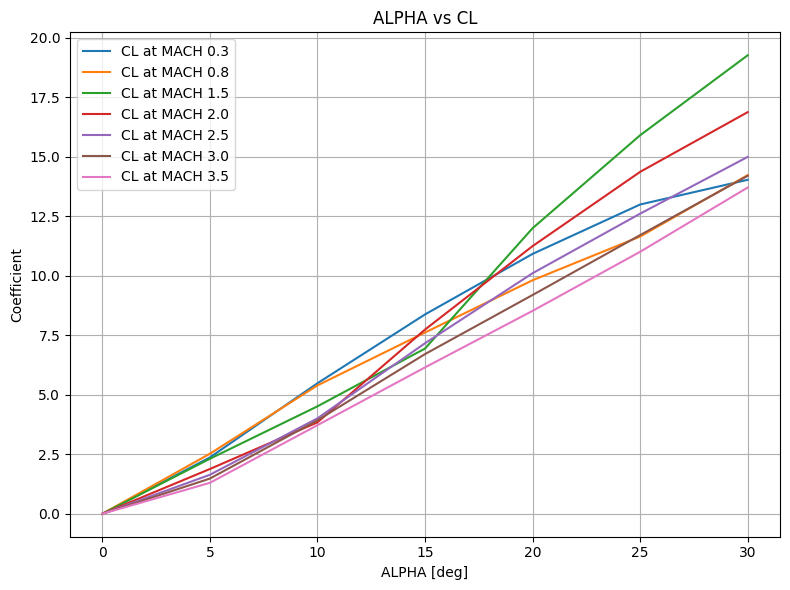

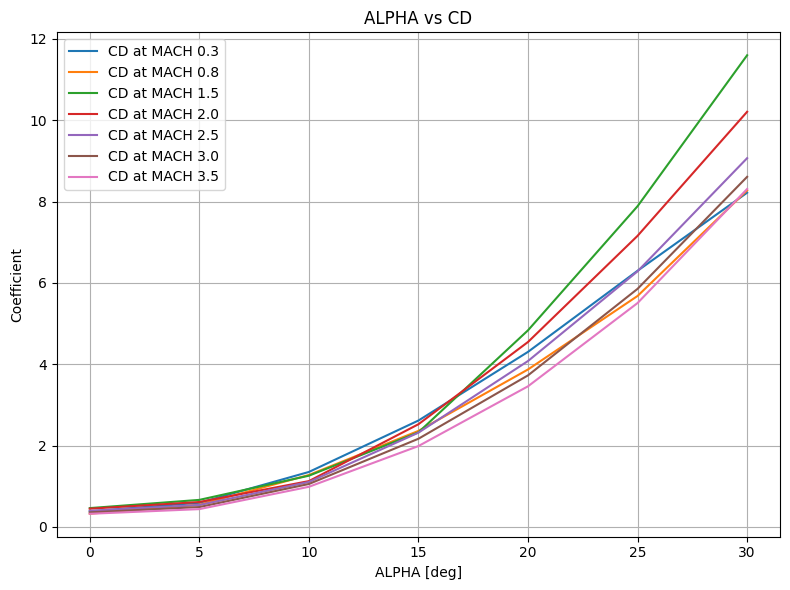

In [7]:
plot_alpha_vs_derivs(data, deriv_name, mach_list=None, mach_values=mach, y_keys=['CL'])
plot_alpha_vs_derivs(data, deriv_name, mach_list=None, mach_values=mach, y_keys=['CD'])

모든 공력계수 Plotting

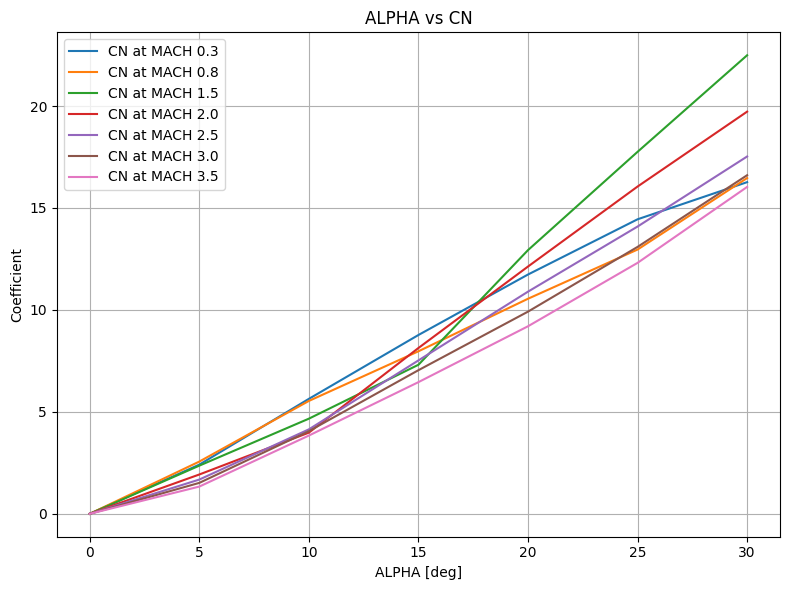

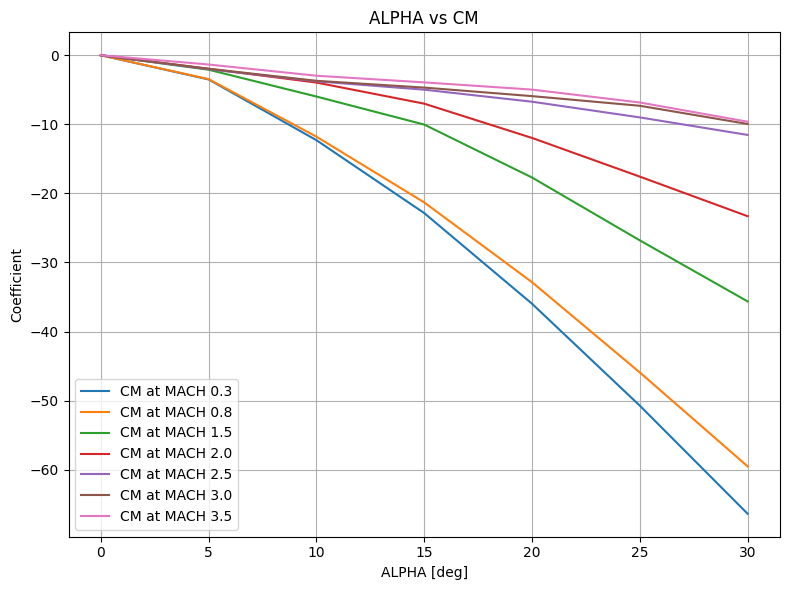

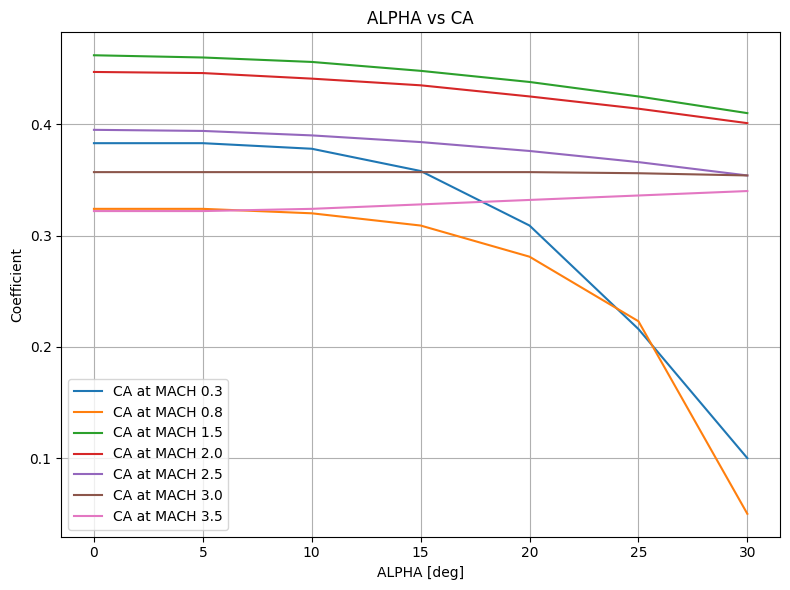

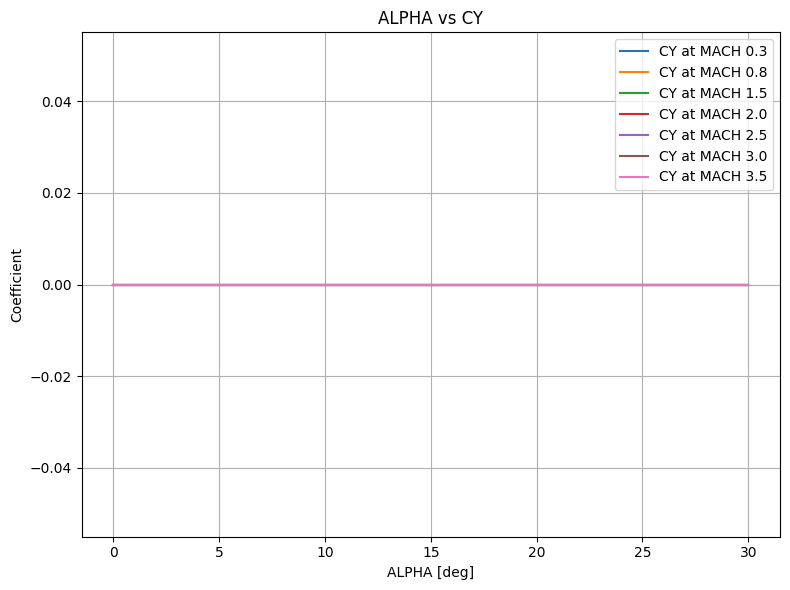

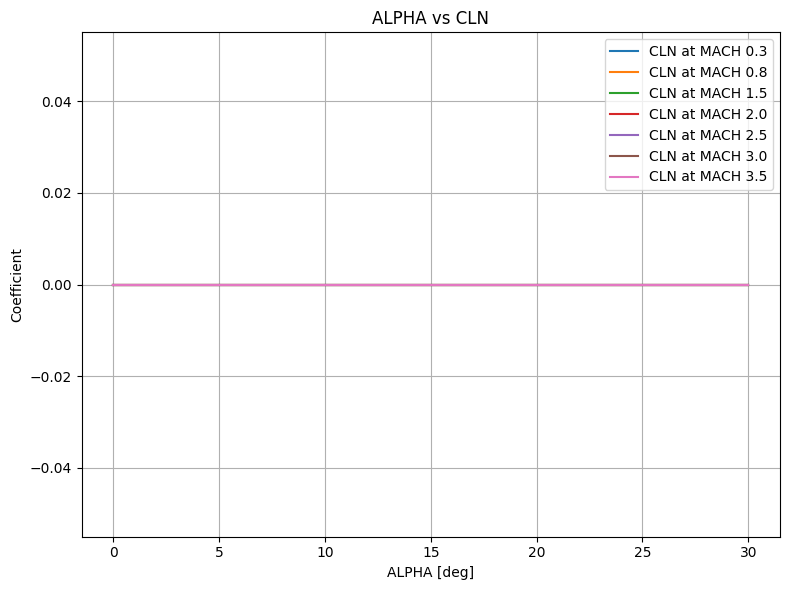

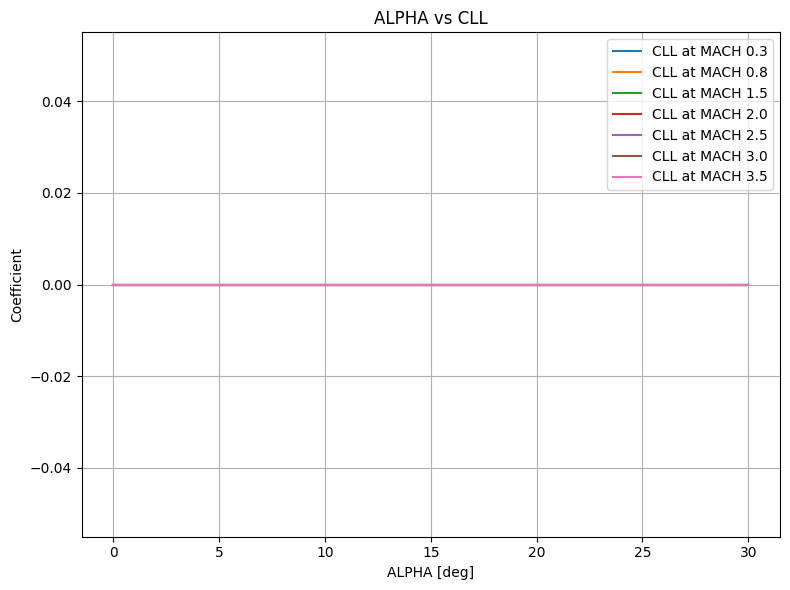

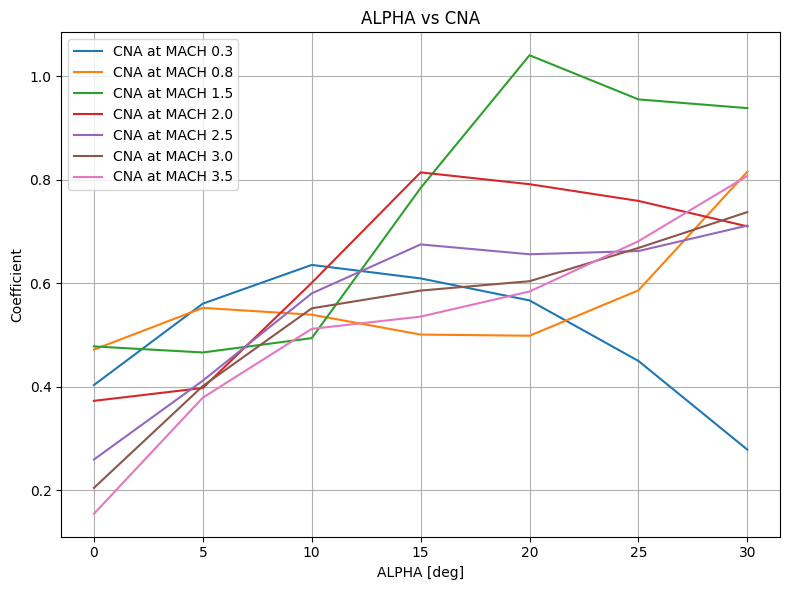

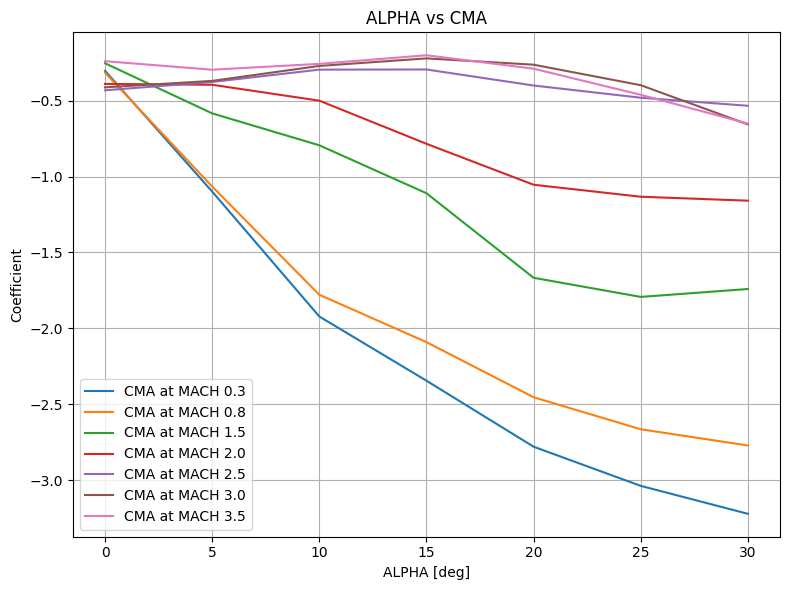

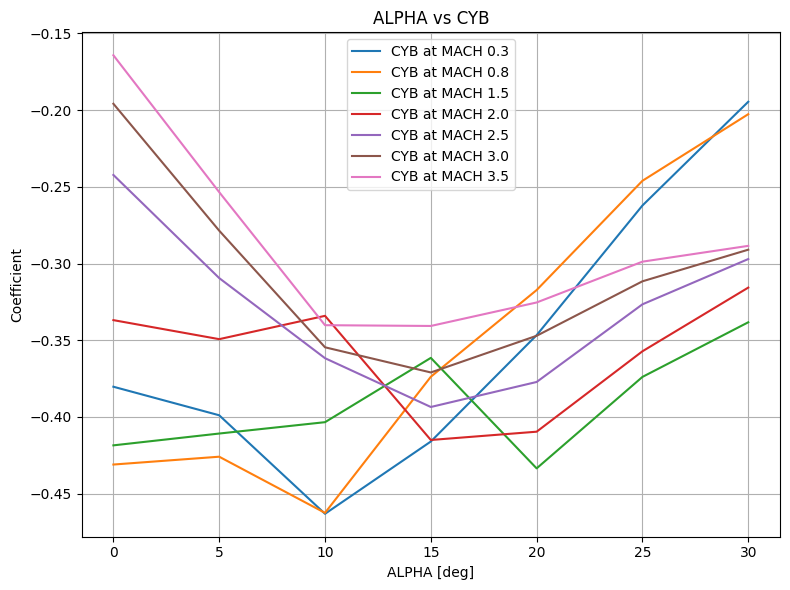

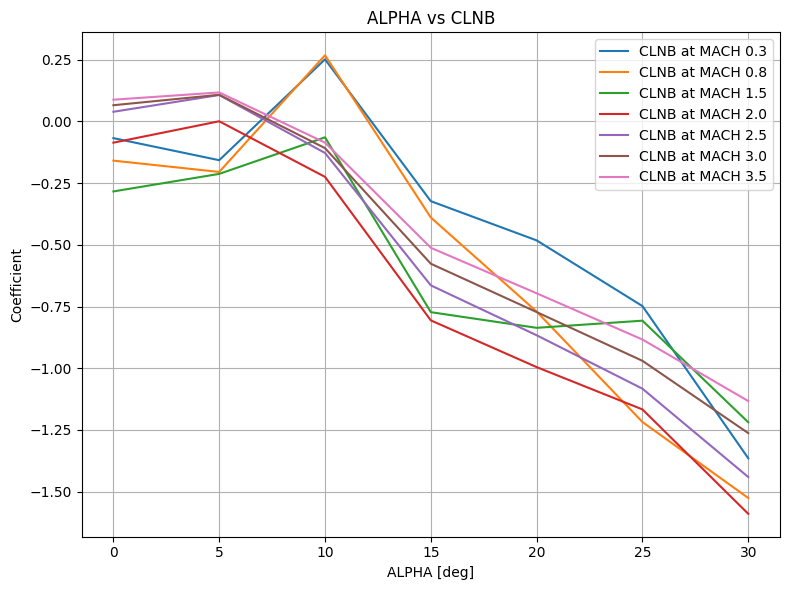

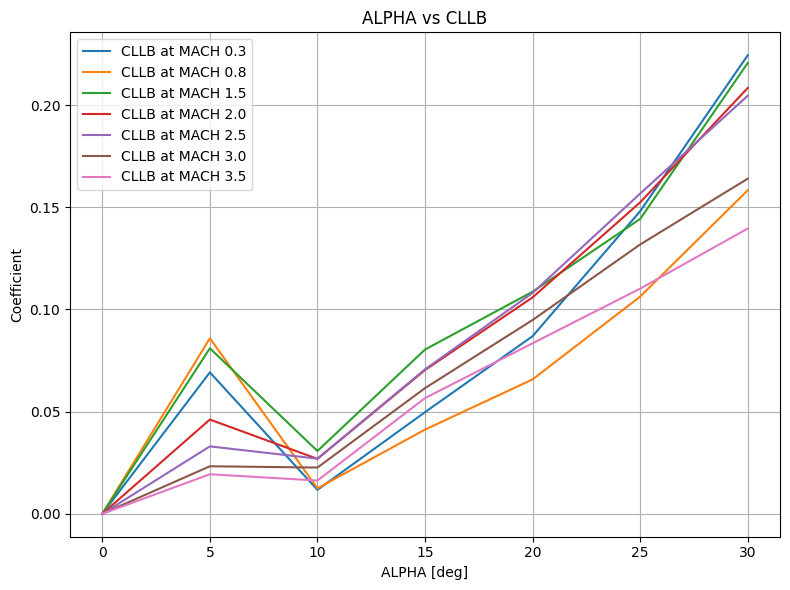

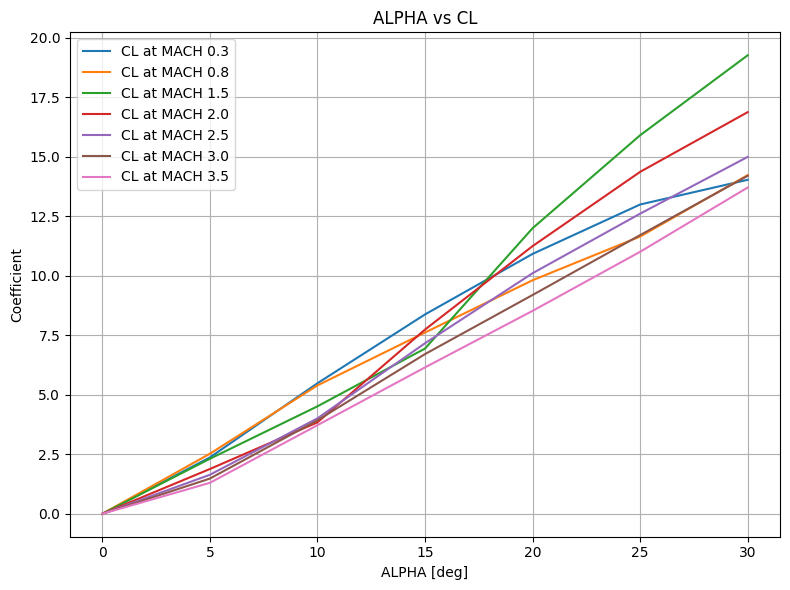

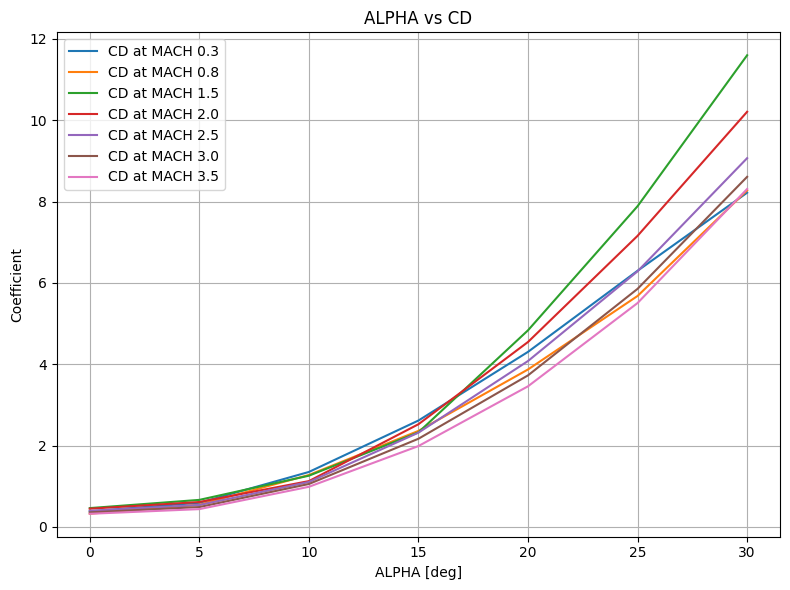

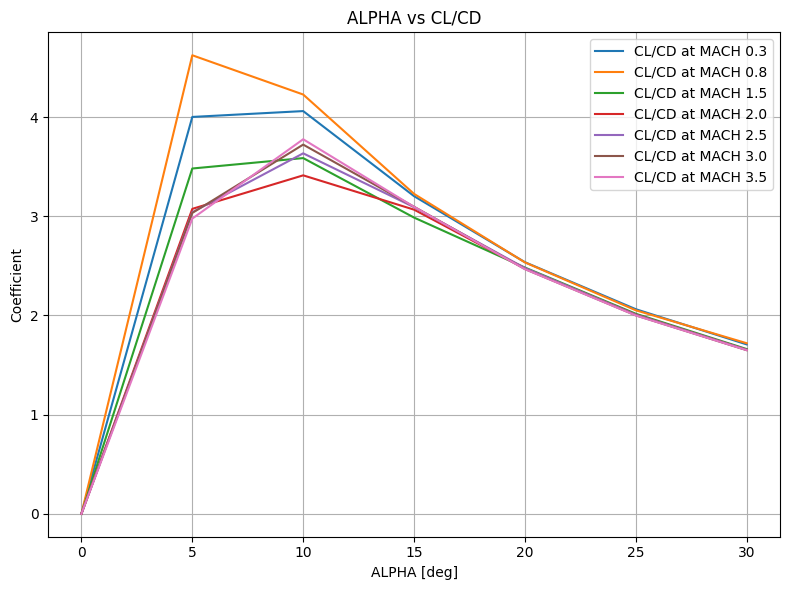

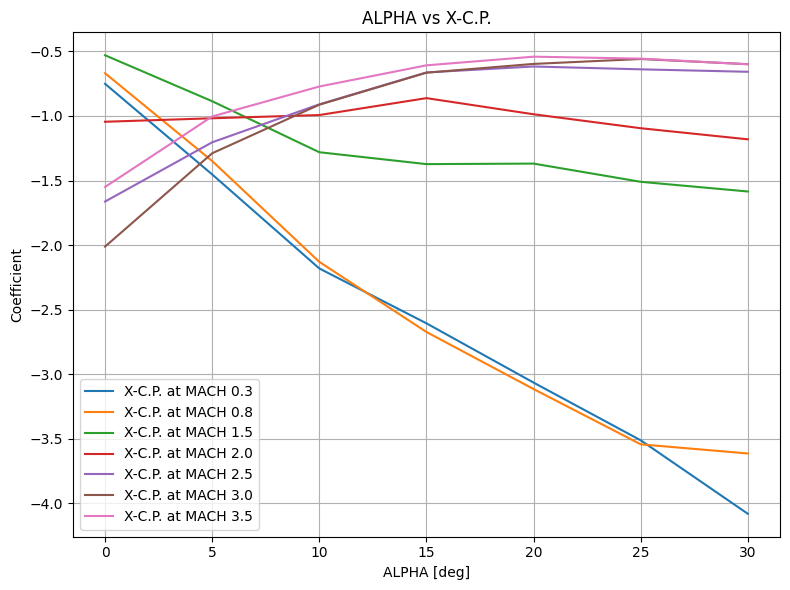

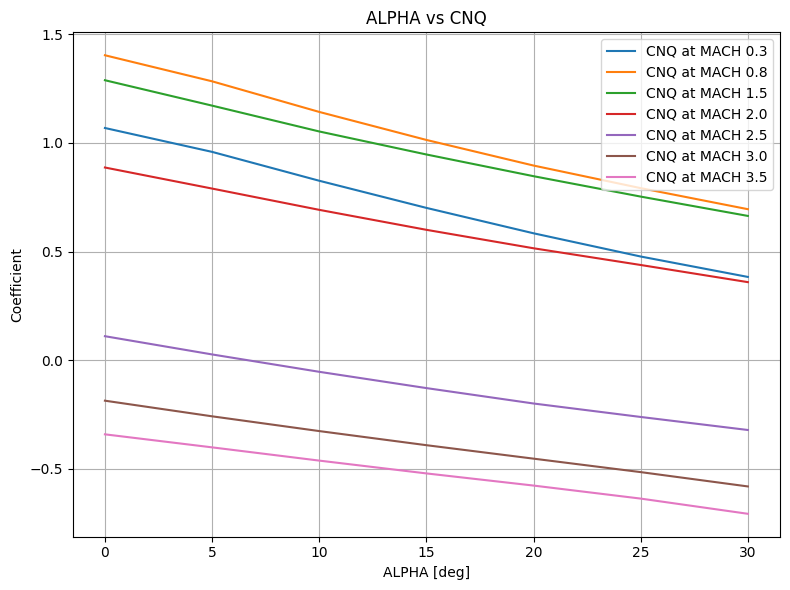

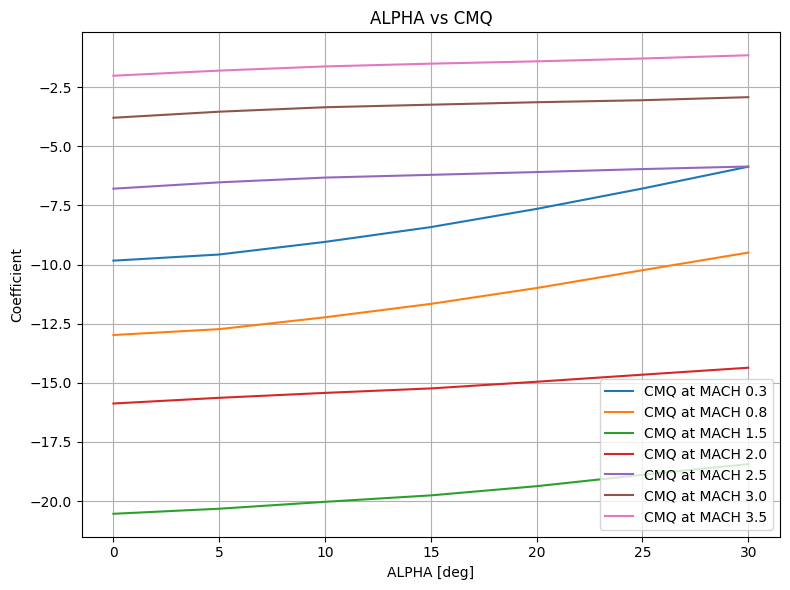

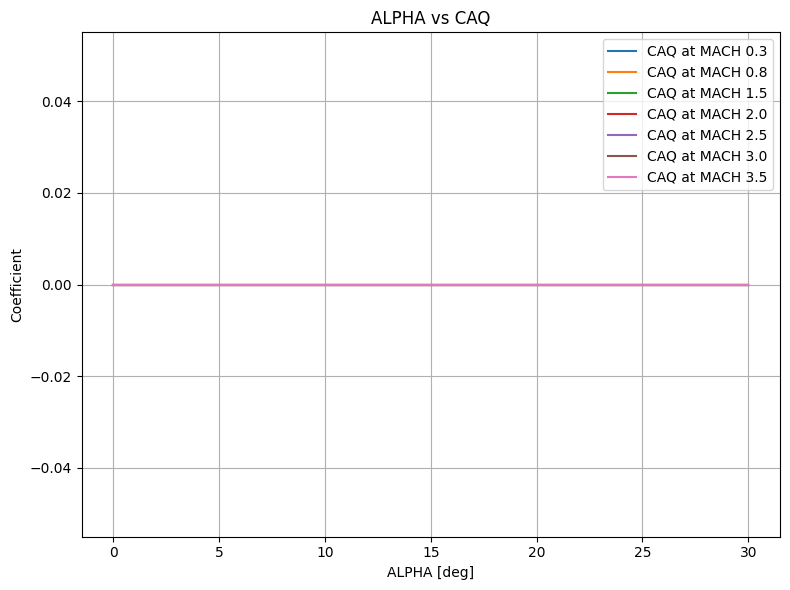

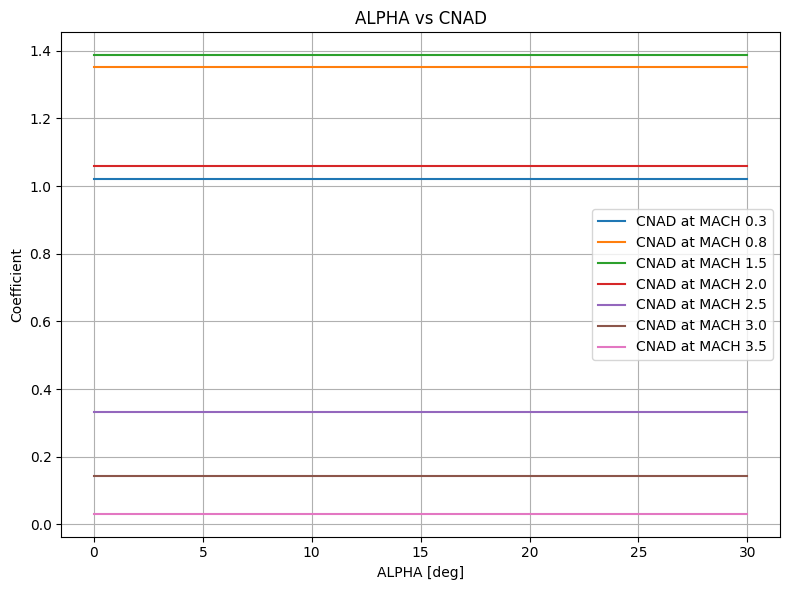

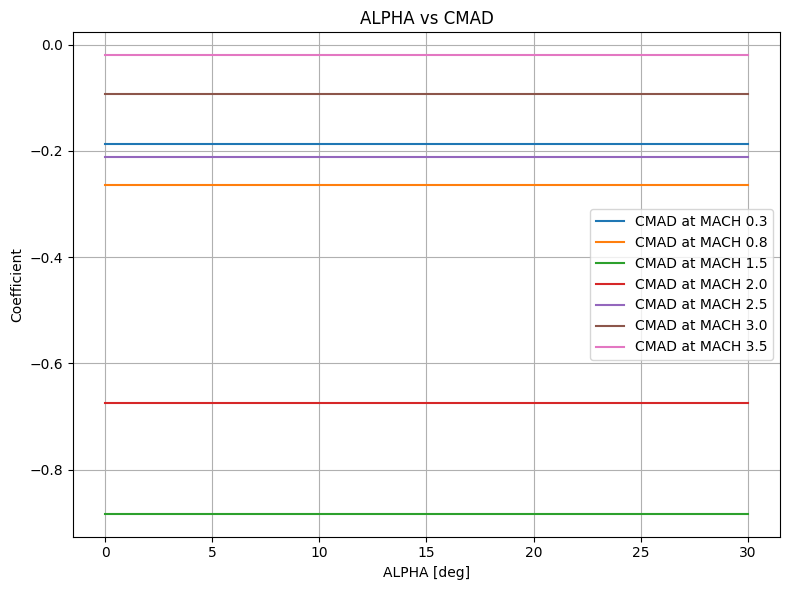

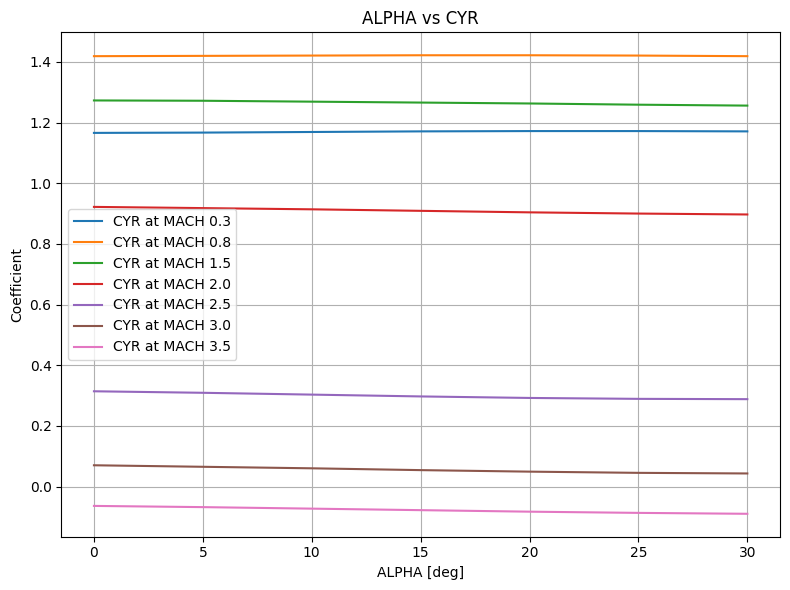

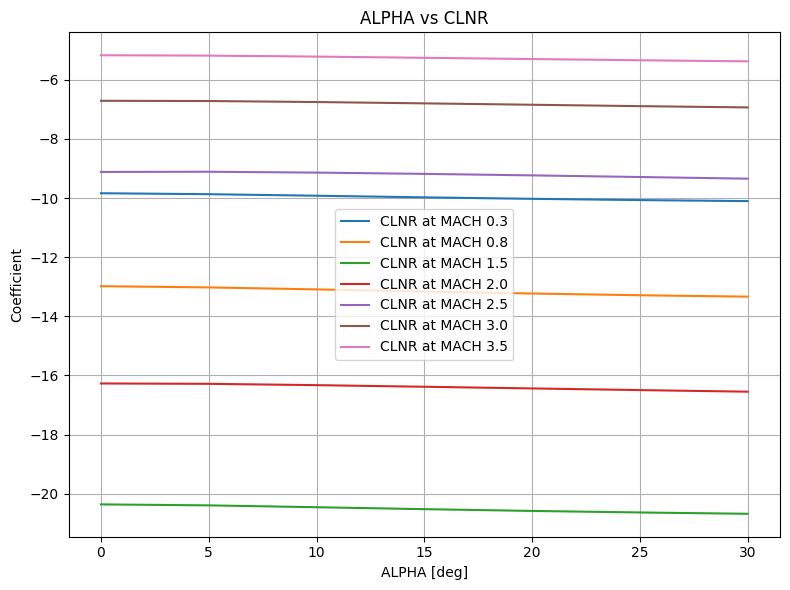

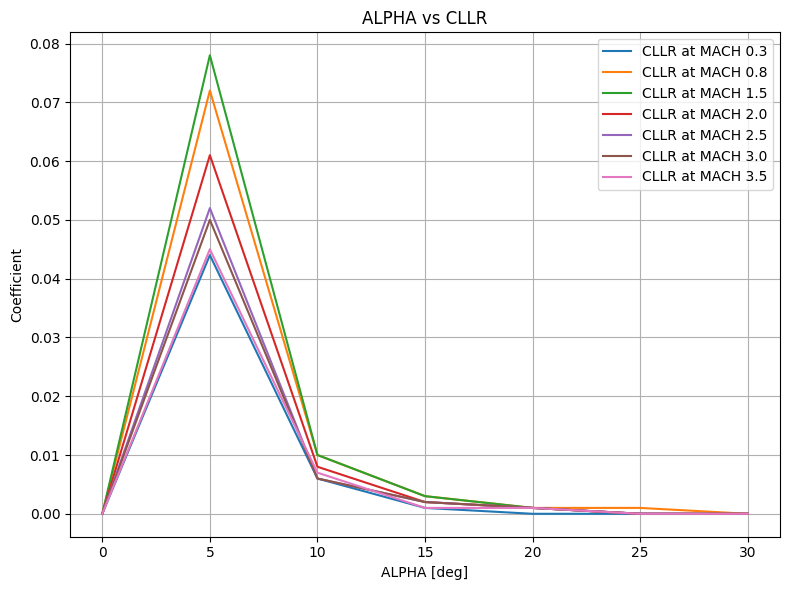

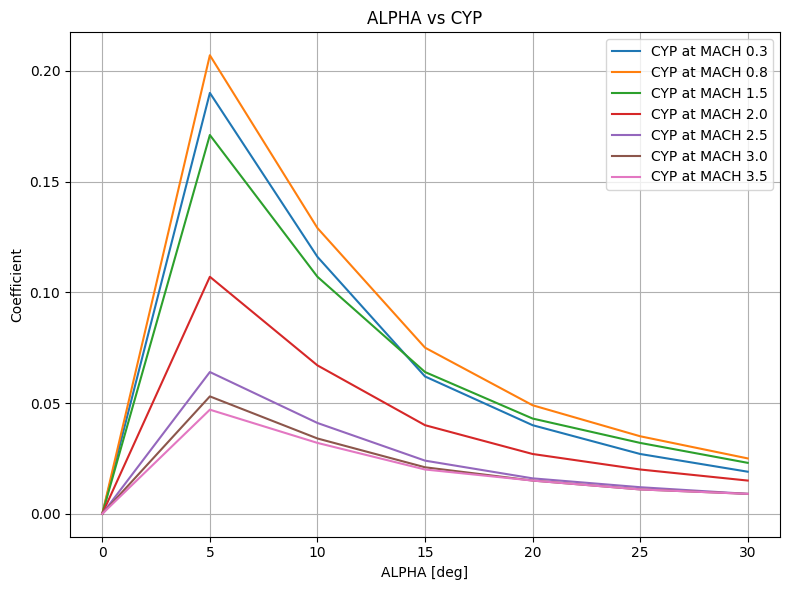

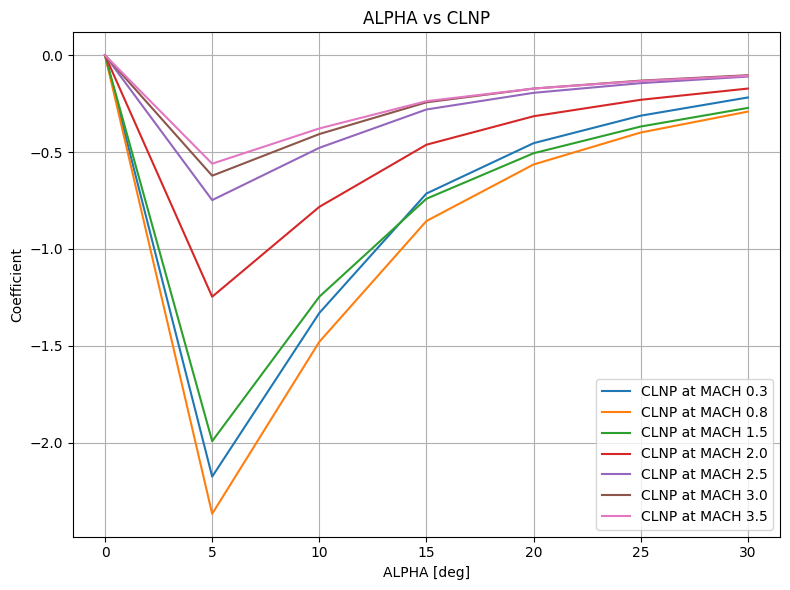

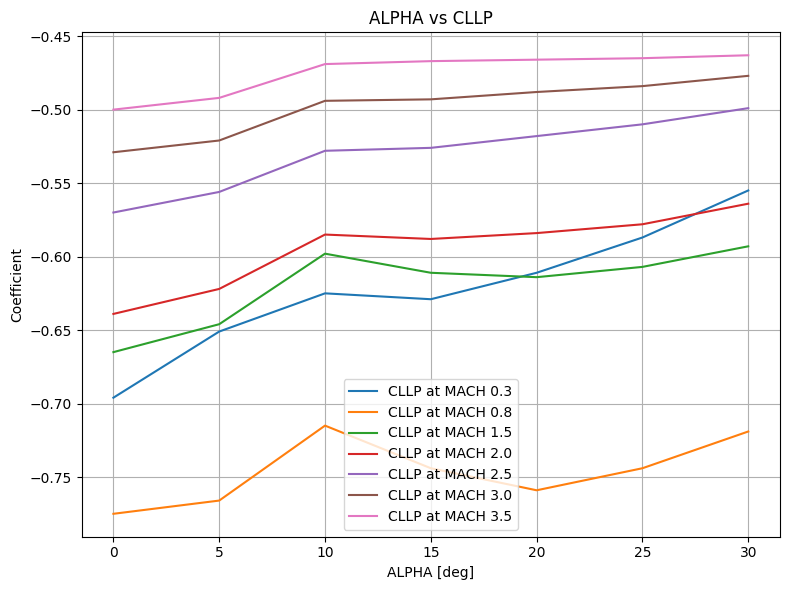

In [8]:
for i in range(1, len(deriv_name)):
    plot_alpha_vs_derivs(data, deriv_name, mach_list=None, mach_values=mach, y_keys=[deriv_name[i]])

Appendix: 마하수별 그래프 그리기

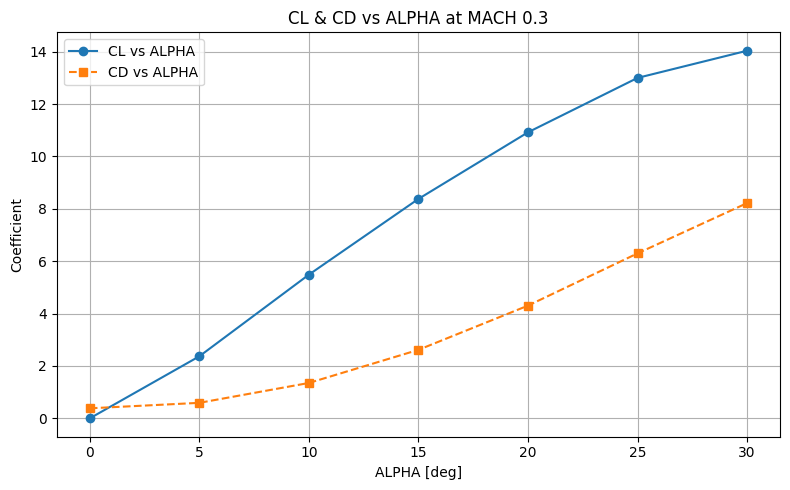

In [11]:
alpha_idx = deriv_name.index('ALPHA')  # 0
cl_idx = deriv_name.index('CL')        # 12
cd_idx = deriv_name.index('CD')        # 13
alpha = data[0, :, alpha_idx]

mach_index = 0

alpha = data[mach_index, :, alpha_idx]
cl = data[mach_index, :, cl_idx]
cd = data[mach_index, :, cd_idx]

plt.figure(figsize=(8, 5))
plt.plot(alpha, cl, 'o-', label='CL vs ALPHA')
plt.plot(alpha, cd, 's--', label='CD vs ALPHA')
plt.xlabel('ALPHA [deg]')
plt.ylabel('Coefficient')
plt.title(f'CL & CD vs ALPHA at MACH {mach[mach_index]}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()